### Abdelrahman Alkhawas Sprint 3
This is my sprint two notebook where I will be Reconfiguring my data for some initial NN experimentation. This notebook assumes that the user has access to `eeaao.csv` or has run the latest iteration of `webScraping1.py`.

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%pip install tensorflow-gpu==2.10
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Masking, LSTM, Dense, Dropout
from keras.regularizers import l2

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = None
pd.options.display.max_rows = 200
pd.set_option('display.width', 1000)

Note: you may need to restart the kernel to use updated packages.


In [ ]:
print(np.__version__)

In [2]:
# Importing my Data. 
df = pd.read_csv('../data/eeaao.csv')
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,p_id,Season,Player,Nation,Pos,Squad,Comp,Age,Born,"Playing Time, MP","Playing Time, Starts","Playing Time, Min","Playing Time, 90s","Performance, Gls","Performance, Ast","Performance, G+A","Performance, G-PK","Performance, PK","Performance, PKatt","Performance, CrdY","Performance, CrdR","Expected, xG","Expected, npxG","Expected, xAG","Expected, npxG+xAG","Progression, PrgC","Progression, PrgP","Progression, PrgR","Per 90 Minutes, Gls","Per 90 Minutes, Ast","Per 90 Minutes, G+A","Per 90 Minutes, G-PK","Per 90 Minutes, G+A-PK","Per 90 Minutes, xG","Per 90 Minutes, xAG","Per 90 Minutes, xG+xAG","Per 90 Minutes, npxG","Per 90 Minutes, npxG+xAG","Playing Time, MP.1","Playing Time, Min.1","Playing Time, Mn/MP","Playing Time, Min%","Playing Time, 90s.1","Starts, Starts","Starts, Mn/Start","Starts, Compl","Subs, Subs","Subs, Mn/Sub","Subs, unSub","Team Success, PPM","Team Success, onG","Team Success, onGA","Team Success, +/-","Team Success, +/-90","Team Success, On-Off","Team Success (xG), onxG","Team Success (xG), onxGA","Team Success (xG), xG+/-","Team Success (xG), xG+/-90","Team Success (xG), On-Off","Standard, Gls","Standard, Sh","Standard, SoT","Standard, SoT%","Standard, Sh/90","Standard, SoT/90","Standard, G/Sh","Standard, G/SoT","Standard, Dist","Standard, FK","Standard, PK","Standard, PKatt","Expected, xG.1","Expected, npxG.1","Expected, npxG/Sh","Expected, G-xG","Expected, np:G-xG","Total, Cmp","Total, Att","Total, Cmp%","Total, TotDist","Total, PrgDist","Short, Cmp","Short, Att","Short, Cmp%","Medium, Cmp","Medium, Att","Medium, Cmp%","Long, Cmp","Long, Att","Long, Cmp%",Ast,xAG,"Expected, xA","Expected, A-xAG",KP,1/3,PPA,CrsPA,PrgP,Att,"Pass Types, Live","Pass Types, Dead","Pass Types, FK","Pass Types, TB","Pass Types, Sw","Pass Types, Crs","Pass Types, TI","Pass Types, CK","Corner Kicks, In","Corner Kicks, Out","Corner Kicks, Str","Outcomes, Cmp","Outcomes, Off","Outcomes, Blocks","SCA, SCA","SCA, SCA90","SCA Types, PassLive","SCA Types, PassDead","SCA Types, TO","SCA Types, Sh","SCA Types, Fld","SCA Types, Def","GCA, GCA","GCA, GCA90","GCA Types, PassLive","GCA Types, PassDead","GCA Types, TO","GCA Types, Sh","GCA Types, Fld","GCA Types, Def","Tackles, Tkl","Tackles, TklW","Tackles, Def 3rd","Tackles, Mid 3rd","Tackles, Att 3rd","Challenges, Tkl","Challenges, Att","Challenges, Tkl%","Challenges, Lost","Blocks, Blocks","Blocks, Sh","Blocks, Pass",Int,Tkl+Int,Clr,Err,"Touches, Touches","Touches, Def Pen","Touches, Def 3rd","Touches, Mid 3rd","Touches, Att 3rd","Touches, Att Pen","Touches, Live","Take-Ons, Att","Take-Ons, Succ","Take-Ons, Succ%","Take-Ons, Tkld","Take-Ons, Tkld%","Carries, Carries","Carries, TotDist","Carries, PrgDist","Carries, PrgC","Carries, 1/3","Carries, CPA","Carries, Mis","Carries, Dis","Receiving, Rec","Receiving, PrgR"
0,Patrick van Aanholt-NED-1990,2017-2018,Patrick van Aanholt,nl NED,1.0,Crystal Palace,eng Premier League,26,1990,28,25,2184,24.3,5,1,6,5,0,0,7,0,3.1,3.1,2.1,5.2,46.0,92.0,86.0,0.21,0.04,0.25,0.21,0.25,0.13,0.09,0.21,0.13,0.21,28,2184,78,63.9,24.3,25,NaN,21.0,3,NaN,8,1.21,31.0,38.0,-7.0,-0.29,-0.07,32.2,34.7,-2.5,-0.10,-0.66,5,33.0,11,33.3,1.36,0.45,0.15,0.45,23.4,4.0,0,0,3.1,3.1,0.09,1.9,1.9,884.0,1176.0,75.2,14197.0,6422.0,479.0,532.0,90.0,311.0,431.0,72.2,74.0,152.0,48.7,1,2.1,1.8,-1.1,18.0,63.0,28.0,6.0,92.0,1176.0,897.0,276.0,30.0,3.0,2.0,56.0,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,46.0,1.90,24.0,12.0,6.0,2.0,1.0,1.0,4.0,0.16,2.0,0.0,2.0,0.0,0.0,0.0,47.0,32.0,29.0,15.0,3.0,16.0,34.0,47.1,18.0,24.0,5.0,19.0,47.0,94.0,64.0,2.0,1435.0,90.0,445.0,616.0,391.0,32.0,1435.0,31.0,26.0,83.9,5.0,16.1,717.0,3714.0,1966.0,46.0,33.0,7.0,37.0,18.0,711.0,86.0
1,Rolando Aarons-ENG-1995,2017-2018,Rolando Aarons,eng ENG,5.0,Newcastle Utd,eng Premier League,21,1995,4,1,139,1.5,0,0,0,0,0,0,0,0,0.1,0.1,0.0,0.1,7.0,3.0,4.0,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.04,0.04,0.04,4,139,35,4.1,1.5,1,NaN,0.0,3,NaN,7,0.25,1.0,2.0,-1.0,-0.65,-0.46,0.4,2.9,-2.6,-1.66,-1.43,0,2.0,0,0.0,1.29,0.00,0.00,NaN,19.9,0.0,

In [ ]:
for col in df.columns: print(col)

#### Some initial thoughts
Following are some initial thoughts I was planning on tackling this problem that couldnt take off the ground, and whose EDA/planning was too messy/incoherent to make it to this notebook.
<br><br>
I was looking to treat each datapoint as a sentence in typical RNN fashion. This would skip the usual token vectorization since the data is already numeric. However, now comes the question of 'what is a datapoint?' for any given player, do we have 7 datapoints (one for each season) of sentence length 160 and we try to predict the entire next year, or do we have 160 datapoints (one for each feature) of size 7 and we try to predict the next element (word) of that features sequence (sentence)?
<br>
The issue with the first way is that sentences are extremely long and the idea of generating sentences that way can lead to 'jumbled sentenced'. The issue with the second way is that we have to teach 160 models how to interact with each other and we lose any value of using NNs due to lack of interaction of features. 
<br><br>
Whilst the second approach makes no sense to use, the first approach has somoe promise, with some alterations to the structure of the data and the preprocessing techniques. 

---

#### The approach
1. We will runn a similar 'cleaning' operation as in Sprint 2 on the entire dataset to make sure each player has only one datapoint per season
2. For our first attempt we will also filter to only players that have datapoints for every season (so we dont have to worry about putting NaNs into the model) and only try to predict our previously defined 'impact' metrics
3. Generate the cleaned 3D matrix and to a traintest separate X_train and Y_train
4. train a simple (not too many layers/ big layers) LTSM NN 
5. evaluate
##### Problems with Approach 1
- Missing important players (obv)
- Bias towards aging players or players on teams that stay up
##### Places to progress
- train on all players. Will also require funky preprocessing. (update: done. we inserted 'empty' rows for players with missing seasons)
- bigger NN (update: Turns out we are very prone to overfitting and bigger =/= better)
- different activations (update: not really much to do here)
- combine all the above. 


In [3]:
# The objective of this block of code is to consolidate player datapoints such that each player for each season has 'at most' one row. 
# We are also not dealing with any funny business with transfers.
tgb = df.groupby('p_id')  # Group by the unique players. 

seasons = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024']

df_by_pid = {}  # {pid: df}
for pid in tgb.groups.keys():
    if tgb.get_group(pid).shape[0] >= 5:
        df_by_pid[pid] = tgb.get_group(pid)

full_careers = {}  # {pid: cleaned_df}
total = pd.DataFrame()
n_full = 0

# want to get rid of rows where trnsfer window gets in the way. This means for the same season, there are two rows
# If for one of them has Playing Time, Min > 180, ignore this player. Otherwise, take the max. 
for pid in df_by_pid.keys():
    # print(pid)
    omit_player = False
    pid_df = pd.DataFrame()
    # gor into pdf and ensure for each 
    # go through each season JUST TO CHECK WHETHER WE SHOULD OMIT THS PLAYER
    df_by_pid_season = df_by_pid[pid].groupby('Season')  # groupby object where keys are seasons
    for season in df_by_pid_season.groups.keys(): 
        season_df = df_by_pid_season.get_group(season)
        if season_df.shape[0] >= 2 and sum(season_df['Playing Time, Min'] > 270) >= 2: 
            # So we want to drop this season from this player.
            # # We can do this by just ignoring this season and moving on to the next.
            pass
        elif season_df.shape[0] >= 2:
            # This player has two rows for this season, but only one of them is keepable
            # print(f'{pid} transferred in {season}')
            most_mins = season_df['Playing Time, Min'].max()
            season_df = season_df.loc[season_df['Playing Time, Min'] == most_mins]
            pid_df = pd.concat([pid_df, season_df], axis=0)
        else:
            # This season is good to add to this players dataframe. 
            pid_df = pd.concat([pid_df, season_df], axis=0)
    full_careers[pid] = pid_df

    # full_careers[pid] = df_by_pid[pid].loc[df_by_pid_season['Playing Time, Min'].idxmax()]

    if not omit_player and full_careers[pid].shape[0] >= 5:  # This player has at least 5 seasons
        n_full+= 1
        player_data = full_careers[pid]
        # Here we want to find which seasons are missing, then populate them with 'empty' rows. 
        placeholder_value1 = -500
        for season in seasons:
            if season not in list(player_data['Season']):
                # Add the season row with blanks
                # print(f'{pid} needs {season}')
                player_name = player_data['Player'].mode()[0]
                nation = player_data['Nation'].mode()[0]
                born = player_data['Born'].mode()[0]
                position = player_data['Pos'].mode()[0]
                squad = player_data['Squad'].mode()[0]
                comp = player_data['Comp'].mode()[0]

                age = int(season.split('-')[0]) - born              

                new_row = [pid, season, player_name, nation, position, squad, comp, age, born] + [placeholder_value1] * 160
                new_row_df = pd.DataFrame([new_row], columns=df.columns)
                player_data = pd.concat([player_data, new_row_df], ignore_index=True)
                
        total = pd.concat([total, player_data], axis=0)

# Now full careers contans all of the players who have at least 7 datapoints {p_id: df}  717 of them
print(total.shape)

(10178, 169)


In [ ]:
full_careers[pid]

In [ ]:
test_gb = total.groupby('p_id')
for pid in test_gb.groups.keys():
    print(pid)
    assert test_gb.get_group(pid).shape == (7, 169)

In [161]:
total.sort_values(['p_id', 'Season'])

placeholder_value = -999.0
nan_total = total.fillna(placeholder_value)

# Get from total
num_players = total['p_id'].unique().shape[0]
data = nan_total.to_numpy().reshape(num_players, 7, 169)

# We now need to set up the 3d matrix and do a train/test split

players = total['p_id'].unique()
"""
original technique
# Reserving a small portion of the players for testing
train_players, test_players = train_test_split(players, test_size=0.1, random_state=42, shuffle=False)  

# Now put the portions of the players into the 3d format
train_indices = [i for i, player in enumerate(players) if player in train_players]
test_indices = [i for i, player in enumerate(players) if player in test_players]
"""

train_indices, test_indices = train_test_split(list(range(469)), test_size=0.1, random_state=42) 
train_indices, test_indices = list(train_indices), list(test_indices)

# getting non-string features
i_s = [4]
i_s.extend(list(range(7, 169)))  # Numerical indicies for training
ti_s = i_s[3:]  # Numerical indicies for prediction. 
# removing the first three features had a major impact, taking r2_score of the NN from -2000 (you read that right) to -2

split_i = math.ceil(0.85 * num_players)
X_train, Y_train = data[:split_i, :-1, i_s], data[:split_i, -1, ti_s]
X_test, Y_test = data[split_i:, :-1, i_s], data[split_i:, -1, ti_s]

# Ensuring floats for NN
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.float32)



# Scaling
ss = StandardScaler()
X_train = X_train.reshape(-1, len(i_s))
X_train = ss.fit_transform(X_train)
X_train = X_train.reshape(split_i, 6, len(i_s))
X_test = X_test.reshape(-1, len(i_s))
X_test = ss.transform(X_test)
X_test = X_test.reshape(num_players - split_i, 6, len(i_s))

Y_train = Y_train.reshape(-1, len(ti_s))
Y_train = ss.fit_transform(Y_train)
Y_train = Y_train.reshape(split_i, len(ti_s))
Y_test = Y_test.reshape(-1, len(ti_s))
Y_test = ss.transform(Y_test)
Y_test = Y_test.reshape(num_players - split_i, len(ti_s))




In [162]:
# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print(X_train.dtype)

X_train shape: (1236, 6, 163)
Y_train shape: (1236, 160)
X_test shape: (218, 6, 163)
Y_test shape: (218, 160)
float32


In [163]:
# Modelling
# Create initial model
model = keras.Sequential()

# Add just one layer for now
model.add(Masking(mask_value=placeholder_value))
model.add(Masking(mask_value=placeholder_value1))
model.add(layers.LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(layers.LSTM(128, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(layers.Dense(80, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer
model.add(layers.Dense(len(i_s) - 3, activation='linear')) # output layer has ~160 linear nodes

# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001), 
              loss=keras.losses.MeanAbsoluteError())

# Define an Early Stop callback
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, 
                                           verbose=1, restore_best_weights=True)

# fit the model
history = model.fit(X_train, Y_train, 
                    validation_split=0.3,
                    batch_size=64, epochs=1000, verbose=1)

model.evaluate(X_test, Y_test, verbose=0)


Epoch 1/1000
14/14 [==============================] - 13s 217ms/step - loss: 10.1121 - val_loss: 10.0911
Epoch 2/1000
14/14 [==============================] - 0s 32ms/step - loss: 10.0636 - val_loss: 10.0487
Epoch 3/1000
14/14 [==============================] - 0s 23ms/step - loss: 10.0222 - val_loss: 10.0084
Epoch 4/1000
14/14 [==============================] - 0s 23ms/step - loss: 9.9821 - val_loss: 9.9686
Epoch 5/1000
14/14 [==============================] - 0s 22ms/step - loss: 9.9424 - val_loss: 9.9291
Epoch 6/1000
14/14 [==============================] - 0s 21ms/step - loss: 9.9028 - val_loss: 9.8897
Epoch 7/1000
14/14 [==============================] - 0s 23ms/step - loss: 9.8636 - val_loss: 9.8505
Epoch 8/1000
14/14 [==============================] - 0s 25ms/step - loss: 9.8243 - val_loss: 9.8114
Epoch 9/1000
14/14 [==============================] - 0s 22ms/step - loss: 9.7853 - val_loss: 9.7724
Epoch 10/1000
14/14 [==============================] - 0s 20ms/step - loss: 9.7462 

0.7321414947509766

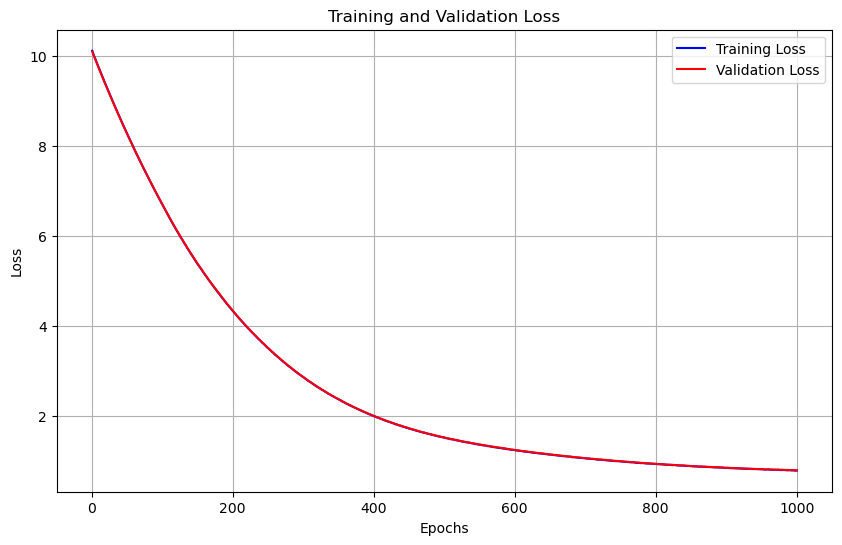

In [164]:
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
i = -30
player = players[i]
print(player)
hist, act = X_test[i], Y_test[i]
hist = hist.reshape(1, 6, 163)
pred = model.predict(hist)
print(hist.shape)
for feat_i in range(X_train.shape[2]):
    print(f'  feature: {df.columns[i_s[feat_i + 3]]}')
    print(f'    {hist[0, :, feat_i+3]}, -> {np.round(pred, 2)[0, feat_i]} vs {np.round(act[feat_i], 2)}')

In [166]:
def find_sim_player(p_id: str, szn: str) -> str:
    """
    a function That, given a players id, will return the player whose next season more resembles that player
    pid: the player we most want to replicate
    sn: the season of that player we most want to replicate. 
    """
    szn_hist = df.loc[(df['p_id'] == p_id) & (df['Season'] == szn)].reset_index()
    pos1 = szn_hist['Pos'][0]
    szn_hist = szn_hist.fillna(placeholder_value)
    szn_hist = szn_hist.to_numpy()

    total.sort_values(['p_id', 'Season'])
    pids = total['p_id'].unique()  # Get a list of all the unique player ids

    coss = []
    mses = []

    total = ss.fit_transform(total)

    for player in pids:
        p_df = total.loc[total['p_id'] == player]  # Get the historical data for this player. 
        # We need to pad the data
        player_data = p_df
        placeholder_value1 = -500
        for season in seasons:
            if season not in list(player_data['Season']):
                # Add the season row with blanks
                # print(f'{pid} needs {season}')
                player_name = player_data['Player'].mode()[0]
                nation = player_data['Nation'].mode()[0]
                born = player_data['Born'].mode()[0]
                position = player_data['Pos'].mode()[0]
                squad = player_data['Squad'].mode()[0]
                comp = player_data['Comp'].mode()[0]

                age = int(season.split('-')[0]) - born              

                new_row = [pid, season, player_name, nation, position, squad, comp, age, born] + [placeholder_value1] * 160
                new_row_df = pd.DataFrame([new_row], columns=df.columns)
                player_data = pd.concat([player_data, new_row_df], ignore_index=True)
        # player_data.reset_index(inplace=True)
        pos2 = player_data['Pos'].mode()[0]
        # now we take the 6 most recent seasons as our model expects 6 seasons
        player_data = player_data.fillna(placeholder_value)

        player_data = player_data.to_numpy().reshape(1, 7, 169)
        p_hist = player_data[:, -6:, i_s].astype(np.float32)
        p_pred = model.predict(p_hist)
        
        pos_sim = float(((7 - abs(pos1 - pos2))/7))
        print(f'pos1: {pos1}, pos2: {pos2}, pos_sim: {pos_sim}')
        print(f'hist: {p_pred.shape}, szn: {szn_hist[:, i_s[3:]].shape}')
        cos = (cosine_similarity(p_pred, szn_hist[:, i_s[3:]])) * (pos_sim)
        mse = (mean_squared_error(p_pred, szn_hist[:, i_s[3:]], squared=True)) * (pos_sim)
        coss.append(cos)
        mses.append(mse)
    print(f'Most similar by cosine similariy: {pids[coss.index(max(coss))]} with {max(coss)}')
    print(f'Most similar by MSE: {pids[mses.index(max(mses))]} with {max(mse)}')


In [167]:
find_sim_player('Mohamed Salah-EGY-1992', '2017-2018')

UnboundLocalError: local variable 'total' referenced before assignment

In [148]:
mo = df.loc[(df['Player'] == 'Mohamed Salah') & (df['Season'] == '2017-2018')]
lm = df.loc[(df['Player'] == 'Chris Wood') & (df['Season'] == '2023-2024')]

pd.concat([mo, lm], axis=0)

mo = mo.fillna(placeholder_value)
mo = mo.to_numpy()[:, i_s[3:]]
lm = lm.fillna(placeholder_value)
lm = lm.to_numpy()[:, i_s[3:]]

print(cosine_similarity(mo, lm), mean_squared_error(mo, lm, squared=False))
lm

[[0.92663232]] 202.4258125


array([[31, 20, 1812, 20.1, 14, 1, 15, 14, 0, 0, 0, 0, 11.9, 11.9, 2.1,
        14.0, 16.0, 30.0, 76.0, 0.7, 0.05, 0.75, 0.7, 0.75, 0.59, 0.1,
        0.7, 0.59, 0.7, 31, 1812, 58, 53.0, 20.1, 20, 83.0, 13.0, 11,
        14.0, 0, 0.94, 28.0, 34.0, -6.0, -0.3, 0.37, 29.5, 26.5, 3.0,
        0.15, 0.5, 14, 48.0, 26, 54.2, 2.38, 1.29, 0.29, 0.54, 10.2, 0.0,
        0, 0, 11.9, 11.9, 0.25, 2.1, 2.1, 278.0, 433.0, 64.2, 3415.0,
        784.0, 178.0, 260.0, 68.5, 70.0, 108.0, 64.8, 7.0, 11.0, 63.6, 1,
        2.1, 1.1, -1.1, 22.0, 19.0, 3.0, 0.0, 30.0, 433.0, 428.0, 5.0,
        0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 278.0, 0.0, 12.0,
        44.0, 2.19, 33.0, 0.0, 4.0, 7.0, 0.0, 0.0, 4.0, 0.2, 1.0, 0.0,
        3.0, 0.0, 0.0, 0.0, 7.0, 4.0, 1.0, 4.0, 2.0, 3.0, 9.0, 33.3, 6.0,
        11.0, 3.0, 8.0, 1.0, 8.0, 26.0, 0.0, 628.0, 34.0, 80.0, 311.0,
        237.0, 92.0, 628.0, 17.0, 6.0, 35.3, 9.0, 52.9, 295.0, 949.0,
        477.0, 16.0, 10.0, 7.0, 50.0, 21.0, 467.0, 76.0]], dtype=object